In [1]:
import numpy as np
from gaussians import Gaussians
import json
import cv2
import pickle
import torch
from torch import nn
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from modules.bilinear_interpolation import BilinearInterpolation

In [2]:
with open('valid.json') as f:
    data = json.load(f)

In [3]:
# !unzip modules.zip

In [4]:
for i in range(len(data)):
    img_name = data[i]['image']

    if img_name != "080436963.jpg":
        continue

    print("found picture")

    # Change the folder here
    img = cv2.imread(img_name)
    kpt = np.asarray(data[i]['joints'], dtype=np.int32)
    if img.shape[0] != 368 or img.shape[1] != 368:
        kpt[:, 0] = kpt[:, 0] * (368 / img.shape[1])
        kpt[:, 1] = kpt[:, 1] * (368 / img.shape[0])
        img = cv2.resize(img, (368, 368))
        img = np.array(img)

    g_list = []
    g_list.append(kpt)
    device = "cuda"

    # Pickled model input
    filename = 'epoch.pkl'
    infile = open(filename,'rb')
    model = pickle.load(infile).to(device)
    img_cuda = torch.Tensor(img).unsqueeze(0).permute(0, 3, 1, 2).to(device)
    output = model(img_cuda)
    softmax = nn.Softmax(dim=2)

    # View the 
    input_view = output.view(output.shape[0], output.shape[1], -1)
    output_view = softmax(input_view)
    output = output_view.view(output.shape)
    infile.close()
    bilin = BilinearInterpolation(output_size = (368, 368))
    output = bilin(output)

    outmap = output.cpu().detach().numpy()
    
    heatmapmodel = outmap[0] * 255.0
    break

found picture


In [5]:
modelOutputJoints = []
print(g_list[0][7])
joint = np.argmax(np.transpose(heatmapmodel[7]))
print(joint)
joint = np.unravel_index(joint, (368,368))
print(joint)

[231 217]
0
(0, 0)


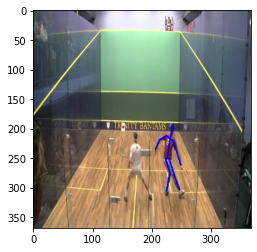

In [6]:
groundTruthList = []

def addJointExists(jointA, jointB, lineList):
  if tuple(g_list[0][jointA]) != -1 and tuple(g_list[0][jointB]) != -1:
    lineList.append(cv2.line(img,tuple(g_list[0][jointA]), tuple(g_list[0][jointB]),(255,0,0),2))

addJointExists(0, 1, groundTruthList)
addJointExists(1, 2, groundTruthList)
addJointExists(5, 4, groundTruthList)

addJointExists(4, 3, groundTruthList)
addJointExists(2, 6, groundTruthList)
addJointExists(3, 6, groundTruthList)

addJointExists(6, 7, groundTruthList)
addJointExists(7, 8, groundTruthList)
addJointExists(8, 9, groundTruthList)

addJointExists(10, 11, groundTruthList)
addJointExists(11, 12, groundTruthList)
addJointExists(12, 7, groundTruthList)

addJointExists(15, 14, groundTruthList)
addJointExists(14, 13, groundTruthList)
addJointExists(13, 7, groundTruthList)


for i in range(len(groundTruthList)):
    plt.imshow(groundTruthList[i][...,::-1])

In [7]:
# 0 = foot, 1 = knee, 2 = pelvis, 3 = pelvis2, 4 = knee2, 5 = foot2, 6 = waist?, 7 = torso, 8 = neck
# 9 = head, 10 = hand, 11 = elbow, 12 = shoulder, 13 = shoulder2, 14 = elbow2, 15 = hand2